In [2]:
import cv2
import numpy as np
np.__version__
np.set_printoptions(suppress=True)

from matplotlib import pyplot as plt
from matplotlib import transforms
%matplotlib inline

from sklearn.decomposition import PCA
from tensorflow.keras.models import load_model
from sklearn.linear_model import LinearRegression
import os
import pdb
from statistics import mean
import math
import pickle

In [57]:
############ function definition ############

# 灰階直方圖均化 ( 若只有一張圖片 img，則輸入 histogram([img],0) )
def histogram(frames,framenumber):
    frame_hist = frames[framenumber].copy()
    hist,bins = np.histogram(frame_hist.flatten(),256,[0,256])

    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/cdf.max()

    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max() - cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')

    frame_hist = cdf[frame_hist]
    
    return frame_hist

#找可能為物件（指標、刻度、數字）的輪廓
def find_obj_contours(frames,framenumber, canny_param1, canny_param2):
    # Input image, Canny's param1, param2, Area lower bound, Area upper bound
    
    frame = frames[framenumber].copy()
    
    # ------- 邊緣偵測 -------
    canny = cv2.Canny(frame, canny_param1, canny_param2)
    
    # ------- 找輪廓 -------
    ( cnts , __ ) = cv2.findContours(canny, 
                                    cv2.RETR_EXTERNAL,
                                    cv2.CHAIN_APPROX_SIMPLE)

    # loop over the contours individually
    contour_objs = []
    for idx, c in enumerate(cnts):
        contour_objs.append(c)
    
    return contour_objs

# 用 [ x for x in contours_obj if len(x)>1 ] 代替
# # contour 只會紀錄轉折點，所以長度不是真正的邊長
# # 過濾大小
# def get_larger_contours(cnts,pixel_lb):
#     contour_objs = []
#     for idx, c in enumerate(cnts):
#         if (c.shape[0] > pixel_lb):
#             contour_objs.append(c)
#     return contour_objs

# 過濾大小
def get_larger_area(cnts,area_lb):
    contour_objs = []
    for idx, c in enumerate(cnts):
        if (cv2.contourArea(c) > area_lb):
            contour_objs.append(c)
    return contour_objs

# 去掉太邊緣的輪廓
def get_inside_contours(frames,framenumber,cnts):
    frame = frames[framenumber].copy()
    inside_contour=[]
    for tar_contour_obj in cnts[framenumber]:
        pts_data = tar_contour_obj.reshape(np.shape(tar_contour_obj)[0], np.shape(tar_contour_obj)[2])

        box_min_x = np.min(pts_data[:, 0])
        box_max_x = np.max(pts_data[:, 0])
        box_min_y = np.min(pts_data[:, 1])
        box_max_y = np.max(pts_data[:, 1])

        box_min_x = int(max( box_min_x - (box_max_x - box_min_x) * 0.2, 0 ))
        box_max_x = int(min( box_max_x + (box_max_x - box_min_x) * 0.2, frame.shape[1] ))
        box_min_y = int(max( box_min_y - (box_max_y - box_min_y) * 0.2, 0 ))
        box_max_y = int(min( box_max_y + (box_max_y - box_min_y) * 0.2, frame.shape[0] ))

        side_len = max(box_max_y - box_min_y , box_max_x - box_min_x)/2
        xm = mean([box_max_x,box_min_x])
        ym = mean([box_max_y,box_min_y])

        box_min_x = int(math.ceil(xm - side_len))
        box_max_x = int(math.floor(xm + side_len))
        box_min_y = int(math.ceil(ym - side_len))
        box_max_y = int(math.floor(ym + side_len))

        if (box_min_x >= 0) and (box_max_x <= frame.shape[1]) and \
           (box_min_y >= 0) and (box_max_y <= frame.shape[0]):
            inside_contour.append(tar_contour_obj)
            
    return inside_contour

# 以長寬比過濾輪廓
# ratio = explained_variance_[1]/explained_variance_[0]，因為 explained_variance_[1] 可能等於 0。
def det_aspectRatio(cnts, ratio_lb=None, ratio_ub=None):
    
    n=0
    if ratio_lb != None:
        n += 1
    if ratio_ub != None:
        n += 1
    
    m=(-1)*n
    desired_cnts = [m]*len(cnts)
    
    for ind, cnt in enumerate(cnts):
        pts_data = cnt.reshape( cnt.shape[0] , cnt.shape[2] )
        pca = PCA(n_components=2)
        pca.fit_transform(pts_data)
        if ratio_lb != None:
            if (pca.explained_variance_[1]/pca.explained_variance_[0]) >= ratio_lb:
                desired_cnts[ind] += 1
        if ratio_ub != None:
            if (pca.explained_variance_[1]/pca.explained_variance_[0]) <= ratio_ub:
                desired_cnts[ind] += 1
    
    desired_indices = [ x[0] for x in enumerate(desired_cnts) if x[1] == 0 ]
    longer_cnts = [ cnts[i] for i in desired_indices ]
    return longer_cnts

# 將輪廓由大排到小
def sortedBySize(cnts):
    
    eigenvalues = [] # 裡面裝 [ind,explained_variance_[0]]
    for ind, cnt in enumerate(cnts):
        pts_data = cnt.reshape(cnt.shape[0],cnt.shape[2])
        pca = PCA(n_components=2)
        pca.fit_transform(pts_data)
        eigenvalues.append([ind,pca.explained_variance_[0]])
    eigenvalues.sort(key=lambda x:x[1], reverse=True)
    
    sorted_cnts=[ cnts[i] for i in np.array(eigenvalues).astype('uint8')[:,0] ]
    
    return np.array(sorted_cnts)

def to_label(num_range,labels):
    range_labeled = []
    for i,label in enumerate(labels):
        range_labeled.append([label,num_range[i]])
    return range_labeled

# 觀察圖片中的所有輪廓
def observe_cnts(frames,framenumber,cnts,columns,hieght):
    rows = math.ceil(len(cnts[framenumber])/columns)
    fig = plt.figure(figsize=(25, hieght))
    ax=[]
    
    for i in range(len(cnts[framenumber])):
        frame = frames[framenumber].copy()
        cv2.drawContours(frame, cnts[framenumber], i, (255, 0, 0), 1)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(str(i)+"-th : "+str(len(cnts[framenumber][i]))+" pixels\narea: "+str(cv2.contourArea(cnts[framenumber][i])))
        plt.imshow(frame, cmap=plt.get_cmap('gray'),vmin=0,vmax=255)

# 只取某個區域內的輪廓
def cnts_in_some_region(cnts,x_lb,x_ub,y_lb,y_ub):
    restricted_cnts =[]
    for cnt in cnts:
        temp = cnt.reshape(cnt.shape[0],cnt.shape[2])
        x_min = np.min(temp[:,0])
        x_max = np.max(temp[:,0])
        y_min = np.min(temp[:,1])
        y_max = np.max(temp[:,1])
        if (x_min >= x_lb) and (x_max <= x_ub) and (y_min >= y_lb) and (y_max <= y_ub):
            restricted_cnts.append(cnt)
    return restricted_cnts

# 將同一張 frame 的各個輪廓分開顯示
def display_cnts(frames,framenumber,contours_obj,hieght):
    columns = 3
    rows = math.ceil(len(contours_obj[framenumber])/columns)
    fig = plt.figure(figsize=(25, hieght))
    ax=[]
    
    for i in range(len(contours_obj[framenumber])):
        
        frame = frames[framenumber].copy()
        cv2.drawContours(frame, contours_obj[framenumber], i, (255, 0, 0), 1)
        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(str(i))
        plt.imshow(frame, cmap=plt.get_cmap('gray'),vmin=0,vmax=255)

# 顯示人工標紀的結果
def display_labels(frames,framenumber,ranges_labeled,hieght):
    columns = 8
    rows = math.ceil(len(ranges_labeled[framenumber])/columns)
    fig = plt.figure(figsize=(25, hieght))
    ax=[]
    
    for i in range(len(ranges_labeled[framenumber])):
        
        frame = frames[framenumber].copy()
        
        label,[box_min_x, box_max_x, box_min_y, box_max_y] = ranges_labeled[framenumber][i]
        
        num_box = frame[box_min_y:box_max_y, box_min_x:box_max_x]
        
        cv2.rectangle(frame, 
                      (box_min_x, box_min_y), 
                      (box_max_x, box_max_y), 
                      color=(0, 255, 0), 
                      thickness=2)
        cv2.line(frame, 
                 (box_max_x, box_min_y), 
                 (box_min_x, box_max_y), 
                 color=(0, 255, 0),
                 thickness=1)
        cv2.line(frame, 
                 (box_max_x, box_max_y), 
                 (box_min_x, box_min_y), 
                 color=(0, 255, 0), 
                 thickness=1)

        font                   = cv2.FONT_HERSHEY_SIMPLEX
        bottomLeftCornerOfText = (box_max_x, box_max_y)
        fontScale              = 1
        fontColor              = (255, 0, 255)
        lineType               = 2

        cv2.putText(frame, str(label),
                    bottomLeftCornerOfText,
                    font, 
                    fontScale,
                    fontColor,
                    lineType)

        ax.append( fig.add_subplot(rows, columns, i+1) )
        ax[-1].set_title(str(i)+"-th in frame "+str(framenumber)+" : "+str(label))
        plt.imshow(frame, cmap=plt.get_cmap('gray'),vmin=0,vmax=255)
        
        
# npy 圖檔資料的旋轉
def npy_img_rotation(frame):
    # rotate frame
    frame_rotated = np.empty([frame.shape[1],frame.shape[0]])
    for i in range(frame.shape[0]):
        for j in range(frame.shape[1]):
            frame_rotated[j][i]=frame[i][-j]
    frame_rotated = frame_rotated.astype(np.uint8)
    return frame_rotated

# np 的 gray 轉 rgb
def np_gray2rgb(gray_frame):
    rgb_frame = np.stack((gray_frame,)*3, axis=-1)
    return rgb_frame



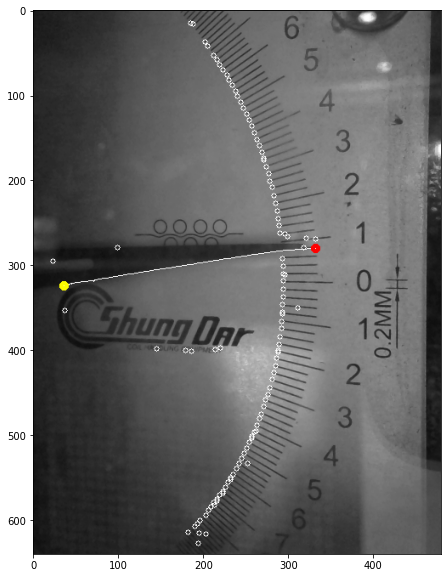

In [60]:
############ 載圖 ############

# load image
frame = np.load('/home/shared_documents/P2019_LEVELING/Dataset/daily/daily_right/20191115_195204.npy')

# # rotate frame
# frame_rotated = np.empty([frame.shape[1],frame.shape[0]])
# for i in range(frame.shape[0]):
#     for j in range(frame.shape[1]):
#         frame_rotated[j][i]=frame[i][-j]
# frame_rotated = frame_rotated.astype(np.uint8)

frame_rotated = npy_img_rotation(frame)

# 灰階直方圖均化
frame_hist = histogram([frame_rotated], 0)

# 原圖
plt.figure(figsize=(10, 10))
plt.imshow(frame_hist, cmap='gray', vmin=0, vmax=255)
plt.title('Raw data (histogram)')

############ 找輪廓 ############

# 找所有輪廓
contours_obj_hist = find_obj_contours(
    [frame_hist],
    0,
    canny_param1=100,
    canny_param2=200)

# 去掉單點輪廓，以符合PCA的條件：n_components=2 must be between 0 and min(n_samples, n_features)=1
nonpt_contours_obj_hist = [x for x in contours_obj_hist if len(x)>1]

# 直接不看右邊的輪廓
region_nonpt_contours_obj_hist = cnts_in_some_region(
    nonpt_contours_obj_hist,
    0,
    360,
    0,
    640)

# 去掉靠近邊界的輪廓
inside_region_nonpt_contours_obj_hist = get_inside_contours(
    [frame_hist],
    0,
    [region_nonpt_contours_obj_hist])

# 去掉長寬比不夠大的輪廓
aspect_inside_region_nonpt_contours_obj_hist = det_aspectRatio(
    inside_region_nonpt_contours_obj_hist,
    ratio_ub=0.1)


############ 把刻度的代表點畫上去（理想上是內圈那點） ############

temp = frame_rotated.copy()

for ind, cnt in enumerate(aspect_inside_region_nonpt_contours_obj_hist):
    pts_data = cnt.reshape(cnt.shape[0],cnt.shape[2])
    
    pca = PCA(n_components=2)
    pca_out = pca.fit_transform(pts_data)
    M, _ = np.argmax(pca_out,axis=0) #因為座標是二維的，而我們只要最大的那個方向的
    m, _ = np.argmin(pca_out,axis=0)

    n = m
    if pts_data[M][0] < pts_data[m][0]:
        n = M
    
    cv2.circle(
        temp,
        (pts_data[n][0], pts_data[n][1]),
        3,
        (255, 0, 0),
        1)
    
# 找出指針的 頭、尾
pointer_rotated_hist = sortedBySize(
    aspect_inside_region_nonpt_contours_obj_hist)[0]

cv2.drawContours(
    temp,
    [pointer_rotated_hist],
    -1,
    (255,0,0),
    1)

pts_data = pointer_rotated_hist.reshape(
    pointer_rotated_hist.shape[0],
    pointer_rotated_hist.shape[2])
pca = PCA(n_components=2)
pca_out = pca.fit_transform(pts_data)
M, _ = np.argmax(pca_out,axis=0)
m, _ = np.argmin(pca_out,axis=0)

h = M # 頭
t = m # 尾
if pts_data[M][0] < pts_data[m][0]:
    h = m
    t = M
    
# gray 轉成 rgb
temp = np_gray2rgb(temp)
    
# 標示頭和尾
cv2.circle(temp, (pts_data[h][0] , pts_data[h][1]) , 3 , (255, 0, 0) , 3) # 頭
cv2.circle(temp, (pts_data[t][0] , pts_data[t][1]) , 3 , (255, 255, 0) , 3) # 尾

plt.figure(figsize=(10, 10))
plt.imshow(temp, vmin=0, vmax=255)

In [ ]:
# 每小時挑一張圖來看一下

dir_name = '/home/shared_documents/P2019_LEVELING/Dataset/daily/daily_right'
total_files = os.listdir(dir_name)

targe_date_hr = ['20191115_' + '{:02}'.format(x) for x in np.arange(8, 19)]
for tar_file in targe_date_hr:
    target_files = sorted([x for x in total_files if tar_file in x])
    tar_data = np.load(os.path.join(dir_name, target_files[0]))
    plt.figure()
    plt.imshow(
        npy_img_rotation(tar_data),
        cmap='gray',
        vmin=0,
        vmax=255)
    plt.title(tar_file)

In [55]:
############ 載圖 ############

# load image
frame = np.load('/home/shared_documents/P2019_LEVELING/Dataset/daily/daily_right/20191115_195204.npy')

# rotate frame
frame_rotated = np.empty([frame.shape[1],frame.shape[0]])
for i in range(frame.shape[0]):
    for j in range(frame.shape[1]):
        frame_rotated[j][i]=frame[i][-j]
frame_rotated = frame_rotated.astype(np.uint8)

# 灰階直方圖均化
frame_hist = histogram([frame_rotated], 0)

############ 找輪廓 ############

# 找所有輪廓
contours_obj_hist = find_obj_contours(
    [frame_hist],
    0,
    canny_param1=100,
    canny_param2=200)

# 去掉單點輪廓，以符合PCA的條件：n_components=2 must be between 0 and min(n_samples, n_features)=1
nonpt_contours_obj_hist = [x for x in contours_obj_hist if len(x)>1]

# 直接不看右邊的輪廓
region_nonpt_contours_obj_hist = cnts_in_some_region(
    nonpt_contours_obj_hist,
    0,
    360,
    0,
    640)

# 去掉靠近邊界的輪廓
inside_region_nonpt_contours_obj_hist = get_inside_contours(
    [frame_hist],
    0,
    [region_nonpt_contours_obj_hist])

# 去掉長寬比不夠大的輪廓
aspect_inside_region_nonpt_contours_obj_hist = det_aspectRatio(
    inside_region_nonpt_contours_obj_hist,
    ratio_ub=0.1)


############ 把刻度的代表點畫上去（理想上是內圈那點） ############

temp = frame_rotated.copy()

for ind, cnt in enumerate(aspect_inside_region_nonpt_contours_obj_hist):
    pts_data = cnt.reshape(cnt.shape[0],cnt.shape[2])
    
    pca = PCA(n_components=2)
    pca_out = pca.fit_transform(pts_data)
    M, _ = np.argmax(pca_out,axis=0) #因為座標是二維的，而我們只要最大的那個方向的
    m, _ = np.argmin(pca_out,axis=0)

    n = m
    if pts_data[M][0] < pts_data[m][0]:
        n = M
    
    cv2.circle(
        temp,
        (pts_data[n][0], pts_data[n][1]),
        3,
        (255, 0, 0),
        1)
    
#標出指針的 頭、尾

pointer_rotated_hist = sortedBySize(
    aspect_inside_region_nonpt_contours_obj_hist)[0]

cv2.drawContours(
    temp,
    [pointer_rotated_hist],
    -1,
    (255,0,0),
    1)

pts_data = pointer_rotated_hist.reshape(
    pointer_rotated_hist.shape[0],
    pointer_rotated_hist.shape[2])
pca = PCA(n_components=2)
pca_out = pca.fit_transform(pts_data)
M, _ = np.argmax(pca_out,axis=0)
m, _ = np.argmin(pca_out,axis=0)

h = M # 頭
t = m # 尾
if pts_data[M][0] < pts_data[m][0]:
    h = m
    t = M
    
cv2.circle(temp, (pts_data[h][0] , pts_data[h][1]) , 3 , (255, 0, 0) , 3) # 頭
cv2.circle(temp, (pts_data[t][0] , pts_data[t][1]) , 1 , (255, 0, 0) , 3) # 尾

plt.figure(figsize=(20, 20))
plt.imshow(temp, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

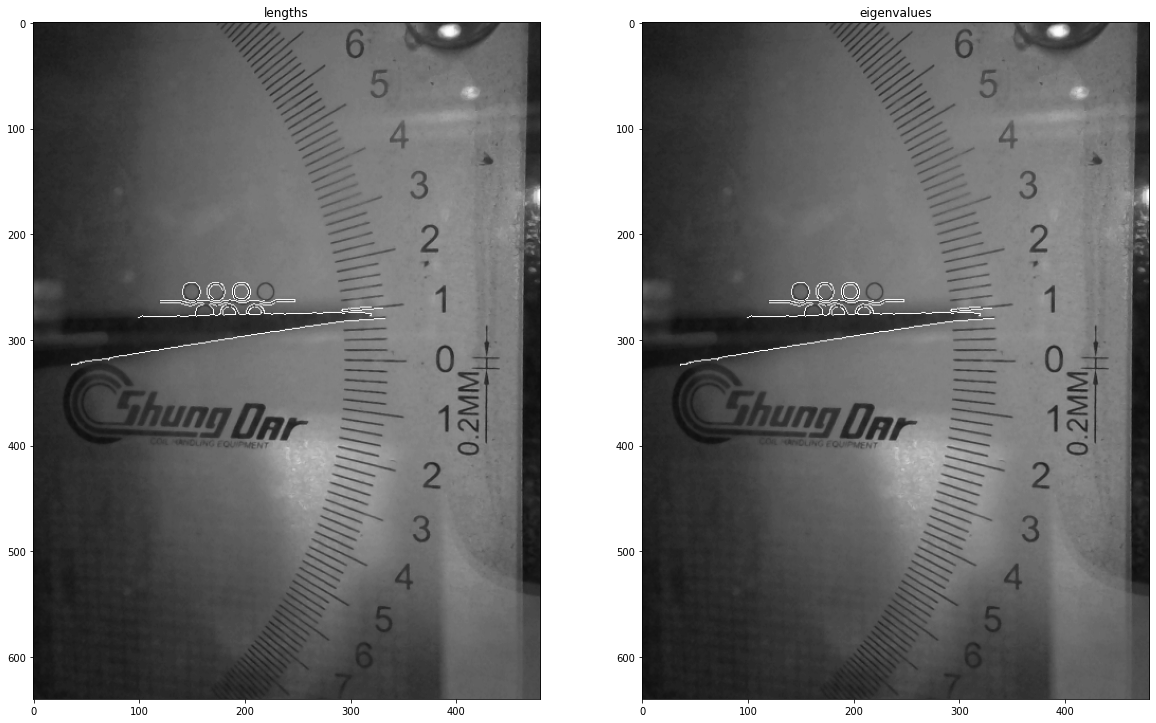

In [9]:
############ 比較「計算長度」與「直接用 eigenvalue」兩種方法 ############

# 得到的「指針」（結果一樣）
lengths = []
eigenvalues = []

for ind, cnt in enumerate(aspect_inside_region_nonpt_contours_obj_hist):
    pts_data = cnt.reshape(cnt.shape[0],cnt.shape[2])
    
    pca = PCA(n_components=2)
    pca_out = pca.fit_transform(pts_data)
    N, _ = np.argmax(pca_out, axis=0)
    n, _ = np.argmin(pca_out, axis=0)
    
    length = math.sqrt((pca_out[N][0]-pca_out[n][0])**2 + (pca_out[N][1]-pca_out[n][1])**2)
    
    lengths.append(length)
    eigenvalues.append(pca.explained_variance_[0])

lengths_sorted = sorted(
    enumerate(lengths),
    key=lambda x:x[1],
    reverse=True)

eigenvalues_sorted = sorted(
    enumerate(eigenvalues),
    key=lambda x:x[1],
    reverse=True)

temp = frame_rotated.copy()
for i in [0, 1]:
    cv2.drawContours(
        temp,
        aspect_inside_region_nonpt_contours_obj_hist,
        lengths_sorted[i][0],
        (255, 0, 0),
        1)
    
plt.figure(figsize=(20, 20))
plt.subplot(121)
plt.title("lengths")
plt.imshow(
    temp,
    cmap='gray',
    vmin=0, vmax=255)

temp = frame_rotated.copy()
for i in [0, 1]:
    cv2.drawContours(
        temp,
        aspect_inside_region_nonpt_contours_obj_hist,
        eigenvalues_sorted[i][0],
        (255, 0, 0),
        1)

plt.subplot(122)
plt.title("eigenvalues")
plt.imshow(temp, cmap=plt.get_cmap('gray'), vmin=0, vmax=255)

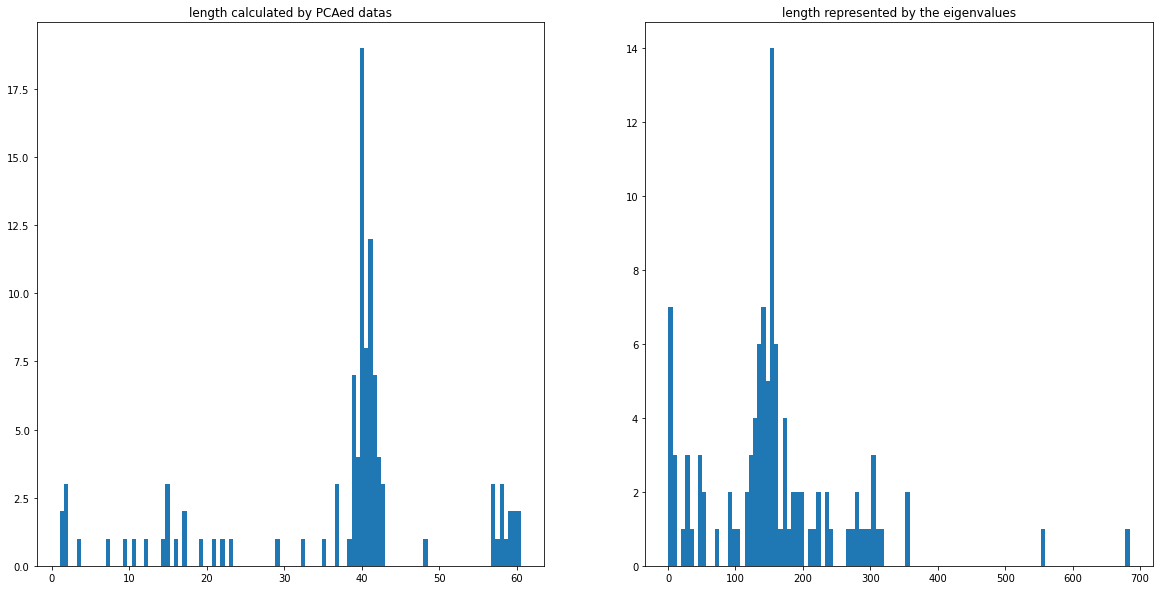

In [5]:
# 輪廓的長度分布圖

lengths = []
eigenvalues = []

for ind, cnt in enumerate(aspect_inside_region_nonpt_contours_obj_hist):
    pts_data = cnt.reshape(cnt.shape[0],cnt.shape[2])
    
    pca = PCA(n_components=2)
    pca_out = pca.fit_transform(pts_data)
    N, _ = np.argmax(pca_out,axis=0)
    n, _ = np.argmin(pca_out,axis=0)
    
    length = math.sqrt((pca_out[N][0]-pca_out[n][0])**2 + (pca_out[N][1]-pca_out[n][1])**2)
    
    lengths.append(length)
    eigenvalues.append(pca.explained_variance_[0])

lengths.sort()
eigenvalues.sort()

lengths = [x[1] for x in enumerate(lengths) if x[0] < len(lengths)-2]
eigenvalues = [x[1] for x in enumerate(eigenvalues) if x[0] < len(eigenvalues)-2]

A = range(len(aspect_inside_region_nonpt_contours_obj_hist))
number = len(aspect_inside_region_nonpt_contours_obj_hist)

plt.figure(figsize=(20, 10))

plt.subplot(121)
plt.title("length calculated by PCAed datas")
plt.hist(lengths, number)

plt.subplot(122)
plt.title("length represented by the eigenvalues")
plt.hist(eigenvalues, number)

plt.show()